In [6]:
# ! unzip "/content/drive/MyDrive/Img-captioning/Flickr8k_Dataset.zip"

In [7]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import re
import string
import json
from time import time
import pickle

In [8]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras_preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add

In [9]:
import nltk
from nltk.corpus import stopwords
import collections

**DATA COLLECTION**

In [10]:
def read_file(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [11]:
captions=read_file("/content/drive/MyDrive/Img-captioning/captions.txt")


In [12]:
print(len(captions.split("\n")))

40461


In [13]:
captions=captions.split("\n")

In [14]:
print(captions[0])
print(captions[1])
print(captions[-1])    # last caption is empty
print(captions[-2])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .

997722733_0cb5439472.jpg#4	A rock climber practices on a rock climbing wall .


In [15]:
captions=captions[:-1]

In [16]:
print(captions[0])    # discarding last caption as it was empty
print(captions[1])
print(captions[-1])
print(captions[-2])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
997722733_0cb5439472.jpg#4	A rock climber practices on a rock climbing wall .
997722733_0cb5439472.jpg#3	A rock climber in a red shirt .


In [17]:
print(len(captions))

40460


In [18]:
descriptions=dict()   # dictionary with key = Image_id and value = a list of captions

In [19]:
for ele in range(10):
    print(captions[ele])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


In [20]:
for ele in captions:                        # populating the descriptions dictionary
    first,second=ele.split("\t")
    img_name=first.split(".")[0]
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    descriptions[img_name].append(second)

In [21]:
print(len(descriptions["1000268201_693b08cb0e"]))

5


In [22]:
for ele in descriptions["1000268201_693b08cb0e"]: print(ele)     # captions 

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [23]:
img_path="/content/drive/MyDrive/Img-captioning/Flicker8k_Dataset"

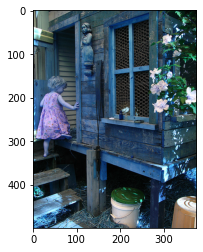

In [24]:
random_img=cv2.imread(img_path+"/1000268201_693b08cb0e.jpg")
plt.imshow(random_img)
plt.show()                                          # captions are matching with image

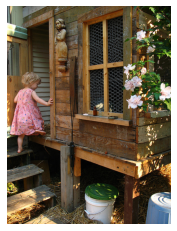

In [25]:
random_img=cv2.cvtColor(random_img,cv2.COLOR_BGR2RGB)   
plt.imshow(random_img)
plt.axis("off")
plt.show()

**TEXT CLEANING**

In [26]:
def clean_text(sen):
    sen=sen.lower()
    sen=re.sub("[^a-z]+"," ",sen)
    sen=sen.split()
    sen=" ".join(sen)
    return sen

In [27]:
for key,cap_list in descriptions.items():
    for i in range(len(cap_list)):
        cap_list[i]=clean_text(cap_list[i])

In [28]:
f=open("descriptions.txt","w")
f.write(str(descriptions))
f.close()

**CREATING VOCAB**

In [29]:
vocab=set()
for key in descriptions.keys():
    for sen in descriptions[key]:
        vocab.update(sen.split())

In [30]:
print(len(vocab))

8441


In [31]:
total_words=[]
for key in descriptions.keys():
    for sen in descriptions[key]:
        for words in sen.split(): total_words.append(words) 

In [32]:
print(len(total_words))

437466


In [33]:
counter=collections.Counter(total_words)
freq_cnt=dict(counter)

In [34]:
print(len(freq_cnt.keys()))

8441


In [35]:
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x: x[1])
threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]

In [36]:
total_words=[x[0] for x in sorted_freq_cnt]   #list having unique words with freq gt than threshold freq

In [37]:
print(len(total_words))

1850


**PREPARE TRAIN TEST DATA**

In [38]:
train_file=read_file("/content/drive/MyDrive/Img-captioning/Flickr_8k.trainImages.txt")
test_file=read_file("/content/drive/MyDrive/Img-captioning/Flickr_8k.testImages.txt")

In [39]:
train=train_file.split("\n")
train=train[:-1]      # last line is empty
print(train[-1])

2671602981_4edde92658.jpg


In [40]:
train=[ele.split(".")[0] for ele in train]
print(train[:5])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87']


In [41]:
test=test_file.split("\n")
print(test[-1])   # last line is empty
test=test[:-1]
print(test[-1])


3490736665_38710f4b91.jpg


In [42]:
test=[ele.split(".")[0] for ele in test]
print(test[:5])

['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01']


In [43]:
train_descriptions=dict()    #contains img_id of images from training set along with "ss+captions+ee"                                  #captions

In [44]:
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_new="ss "+cap+" ee"
        train_descriptions[img_id].append(cap_new)

In [45]:
for ele in train_descriptions["2903617548_d3e38d7f88"]:print(ele)

ss a little baby plays croquet ee
ss a little girl plays croquet next to a truck ee
ss the child is playing croquette by the truck ee
ss the kid is in front of a car with a put and a ball ee
ss the little boy is playing with a croquet hammer and ball beside the car ee


**IMAGE PROCESSING**

In [46]:
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
print(model.summary())

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [47]:
model_new=Model(model.input,model.layers[-2].output)

In [48]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    return img

In [49]:
img_path="/content/drive/MyDrive/Img-captioning/Flicker8k_Dataset/"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


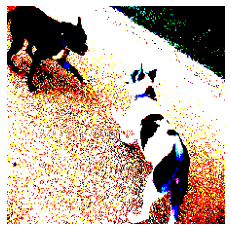

In [50]:
img=preprocess_img("/content/drive/MyDrive/Img-captioning/Flicker8k_Dataset/"+"1001773457_577c3a7d70.jpg")
# img=preprocess_img(random_img)
plt.imshow(img[0])    # converting 4d-tensor to 3d-tensor
plt.axis("off")
# plt.imshow(random_img)
plt.show()

In [51]:
def encode_img(img):
    img=preprocess_img(img)
    feature_vec=model_new.predict(img)
    # print(feature_vec.shape)
    feature_vec=feature_vec.reshape((-1,))
    # print(feature_vec.shape)
    return feature_vec

In [52]:
encode_img(img_path+"1001773457_577c3a7d70.jpg")

array([0.78417987, 0.8189694 , 0.06491425, ..., 0.08858445, 0.6853808 ,
       0.18749645], dtype=float32)

In [53]:
encoding_train=dict()   # storing feature vector for each training image
# i=0                   # comment it and use pickle file
start=time()
for img_id in train:
    path_img=img_path+img_id+".jpg"
    encoding_train[img_id]=encode_img(path_img)
    # i+=1
    # if i%100==0:print("training in progress",i)
end=time()
print("time taken=",end-start)

In [54]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [55]:
encoding_test=dict()   
# i=0
start=time()
for img_id in test:
    path_img=img_path+img_id+".jpg"
    encoding_test[img_id]=encode_img(path_img)
    # i+=1
    # if i%100==0:print("training in progress",i)
end=time()
print("time taken=",end-start)

In [56]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [57]:
with open("/content/drive/MyDrive/Img-captioning/encoded_train_features.pkl","rb") as f:    # pickle load for encoding_test andencoding_train
    encoding_train=pickle.load(f)
# print(encoding_train)
print("loading done")

loading done


In [58]:
with open("/content/drive/MyDrive/Img-captioning/encoded_test_features.pkl","rb") as f:    # pickle load for encoding_test andencoding_train
    encoding_test=pickle.load(f)
# print(encoding_test)
print("loading done")

loading done


In [59]:
# print(encoding_train)

**PREPROCESSING CAPTIONS**

In [60]:
word_to_idx=dict()
idx_to_word=dict()
for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word
last=len(word_to_idx)
print(last)
word_to_idx["ss"]=last+1
idx_to_word[last+1]="ss"
word_to_idx["ee"]=last+2
idx_to_word[last+2]="ee"
vocab_size=len(idx_to_word)+1   # foro zero
last=len(word_to_idx)
print(last)
print(vocab_size)

1850
1852
1853


In [61]:
print(idx_to_word[5])
print(word_to_idx["girl"])

is
17


In [62]:
max_len=0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))

In [63]:
print(max_len)

38


**MAKING CUSTOM DATA GENERATOR**

In [64]:
def data_generator(train_desc,encoding_train,word_to_idx,max_len,batch_size):
    x1,x2,y=[],[],[]
    n=0
    while True:
        for key,desc_list in train_desc.items():
            n+=1
            photo=encoding_train[key]      
            # +'.jpg'
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding="post")[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield ([np.array(x1),np.array(x2)],np.array(y))
                    n=0
                    x1,x2,y=[],[],[]

In [65]:
!unzip "/content/drive/MyDrive/Img-captioning/archive.zip"

Archive:  /content/drive/MyDrive/Img-captioning/archive.zip
  inflating: glove.6B.50d.txt        


In [66]:
f=open("/content/drive/MyDrive/Img-captioning/glove.6B.50d.txt",encoding="utf-8")

In [67]:
embedding_index=dict()
for line in f:
    values=line.split()
    word=values[0]
    word_embeddings=np.array(values[1:],dtype="float")
    embedding_index[word]=word_embeddings

In [68]:
print(embedding_index["girl"])

[-0.34471   0.69563  -0.78086  -0.58482   1.2263    1.2544   -0.76466
  0.40575   0.18862   0.098834  0.32557  -0.31816   0.23869   0.33554
  1.0592   -0.25266  -1.0308    0.70027   0.030457  0.53866  -0.30279
  1.7515    0.3128    1.2103    0.41335  -1.9421   -0.93756   0.32453
  0.52249  -0.86708   2.1258   -0.20377  -0.19061   0.37736   0.66205
  0.50211  -0.12544  -0.83069   0.21155  -1.3091   -0.44973  -0.11648
  0.033598 -0.68382   0.99419  -0.88262   0.56601  -1.327     0.37319
  0.022389]


In [69]:
f.close()

In [70]:
def emb_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        emb_vec=embedding_index.get(word)
        if emb_vec is not None:
            matrix[idx]=emb_vec
    return matrix

In [71]:
embedding_matrix=emb_matrix()
print(embedding_matrix.shape)

(1853, 50)


In [72]:
print(last)
print(embedding_matrix[last])   # ss and ee are present in the embeddings

1852
[ 1.0347    2.1967    1.1182   -0.44528  -1.5944   -1.422    -0.41429
 -1.8638   -0.86332   1.1378   -0.25959   1.8018   -0.39329   1.2401
  0.089999  1.7526   -0.73218  -1.3039    0.82317   1.672    -1.2966
 -0.36759   0.94428   0.56053  -1.1786   -1.6371   -0.16837   0.59888
 -0.682    -0.39279  -0.49019   0.009579 -1.2081    1.5057    1.0076
 -0.84401   0.37071  -0.26217   1.2949    0.51514   0.47997   2.3818
  0.46945   0.12777   0.59245   0.22244   0.43316  -0.6377    0.64054
  0.077589]


**MODEL IMPLEMENTATION**

In [73]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.4)(input_img_features)
inp_img2=Dense(256,activation="relu")(inp_img1)

In [74]:
input_captions=Input(shape=(max_len))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.4)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [75]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation="relu")(decoder1)
outputs=Dense(vocab_size,activation="softmax")(decoder2)

In [76]:
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 50)       92650       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [77]:
print(model.layers[2])

In [78]:
model.layers[2].set_weights=([embedding_matrix])
model.layers[2].trainable=False

In [79]:
model.compile(loss="categorical_crossentropy",optimizer="adam")

**TRAINING MODEL**

In [80]:
epochs=20
batch_size=3
number_pics_per_batch=3
steps=len(train_descriptions)//number_pics_per_batch
def train():
    for i in range(epochs):
      generator=data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
      model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
      model.save("/content/drive/MyDrive/Img-captioning/model_weight/model_"+str(i)+".h5")




In [81]:
# train()

In [82]:
model=load_model("/content/drive/MyDrive/Img-captioning/model_weight/model_19.h5")

In [98]:
def predict_caption(photo):
  in_text="ss"
  for i in range(max_len):
    seq=[word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    seq=pad_sequences([seq],maxlen=max_len,padding="post")
    ypred=model.predict([photo,seq])
    
    ypred=ypred.argmax()
    word=idx_to_word[ypred]
    in_text+=" "+word
    
    if word=="ee": break
    
    
  final_caption=in_text.split()[1:-1]
  final_caption=" ".join(final_caption)
  return final_caption
  

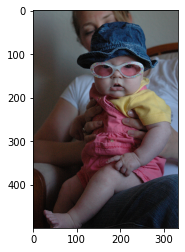

a young boy with a red shirt and a baby


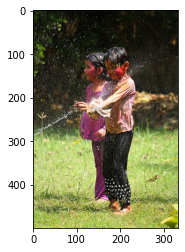

a boy in a red shirt and white shorts is holding a football


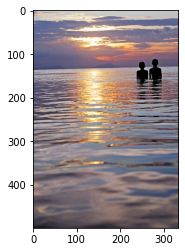

a dog is running through the water


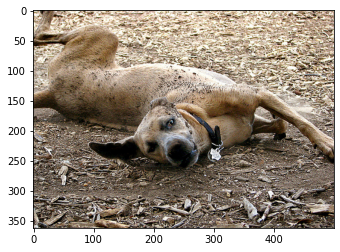

a small dog is sniffing on a small bench


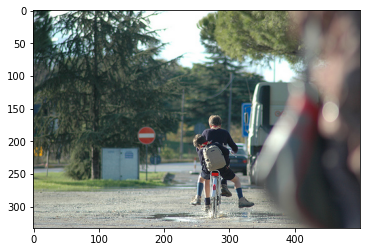

a man in a helmet is riding a unicycle on a street


In [102]:
all_img_names=list(encoding_test.keys())
for i in range(5):
  idx=np.random.randint(250,740)
  img_name=all_img_names[idx]
  photo=encoding_test[img_name].reshape((1,2048))
  i=plt.imread("/content/drive/MyDrive/Img-captioning/Flicker8k_Dataset/"+img_name+".jpg")
  plt.imshow(i)
  plt.show()
  caption=predict_caption(photo)
  print(caption)
